# Classificação de vinhos

In [164]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [165]:
random_seed = 42
df = pd.read_csv('./dataset/winequalityN.csv', sep=',', decimal='.')
df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      45.00                 45.0                 170.0    1.001  3.00   
1      49.00                 14.0                 132.0  994.000  3.30   
2       0.05                 30.0                  97.0    9.951  3.26   
3      58.00                 47.0                 186.0    9.956  3.19   
4      58.00                 47.0                 186.0    9.956  3.19   

   sulphates alcohol  quality  opinion  
0       0.45     8.8        6        1  
1       0.49     9.5        6        1  
2       0.44    10.1        6        1  
3       0.40     9.9        6        1  
4       0.40     9.9        6        1

In [166]:
# Verificar e remover linhas com valores nulos
df.isna().sum()
# A coluna por algum motivo está sendo identificado como string,
# necessário transformar para numérico.
df['alcohol'] = pd.to_numeric(df['alcohol'], errors='coerce')
df = df.dropna()
df_white = df[df['type'] == 'white']

### Tipos de variáveis da base
Variável categórica nominal (type, opinion).

Variável continua (fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol).

Variável ordinal (quality).

In [167]:
df_white.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4836 entries, 0 to 4897
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  4836 non-null   object 
 1   fixed acidity         4836 non-null   float64
 2   volatile acidity      4836 non-null   float64
 3   citric acid           4836 non-null   float64
 4   residual sugar        4836 non-null   float64
 5   chlorides             4836 non-null   float64
 6   free sulfur dioxide   4836 non-null   float64
 7   total sulfur dioxide  4836 non-null   float64
 8   density               4836 non-null   float64
 9   pH                    4836 non-null   float64
 10  sulphates             4836 non-null   float64
 11  alcohol               4836 non-null   float64
 12  quality               4836 non-null   int64  
 13  opinion               4836 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 566.7+ KB


In [168]:
df_white.groupby('type').type.nunique()

type
white    1
Name: type, dtype: int64

### Média e desvio padrão

In [169]:
df_white.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4836.000000       4836.000000  4836.000000     4836.000000   
mean        6.859564         10.874308     0.334404        6.401344   
std         0.842662         67.047754     0.121049        5.078808   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.330000     0.390000        9.900000   
max        14.200000        965.000000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4836.000000          4836.000000           4836.000000  4836.000000   
mean     40.590813            35.292701            138.366315   113.556472   
std      25.029066            17.029113             42.535221   232.561542   
min       0.020000             2.000000              9.000000     0.990000   
25%      33.000000            23.000000            108.000000     9.943000   
50%      42.000000            34.000000            134.000000    98.948500   
75%      49.000000            46.000000            167.000000    99.425000   
max     346.000000           289.000000            440.000000   999.000000   

                pH    sulphates      alcohol      quality      opinion  
count  4836.000000  4836.000000  4836.000000  4836.000000  4836.000000  
mean      3.188141     0.489464    10.513433     5.877171     0.664806  
std       0.151003     0.114062     1.232253     0.886652     0.472107  
min       2.720000     0.220000     8.000000     3.000000     0.000000  
25%       3.090000     0.410000     9.500000     5.000000     0.000000  
50%       3.180000     0.470000    10.400000     6.000000     1.000000  
75%       3.280000     0.550000    11.400000     6.000000     1.000000  
max       3.820000     1.080000    14.200000     9.000000     1.000000

### Análise de separabilidade linear

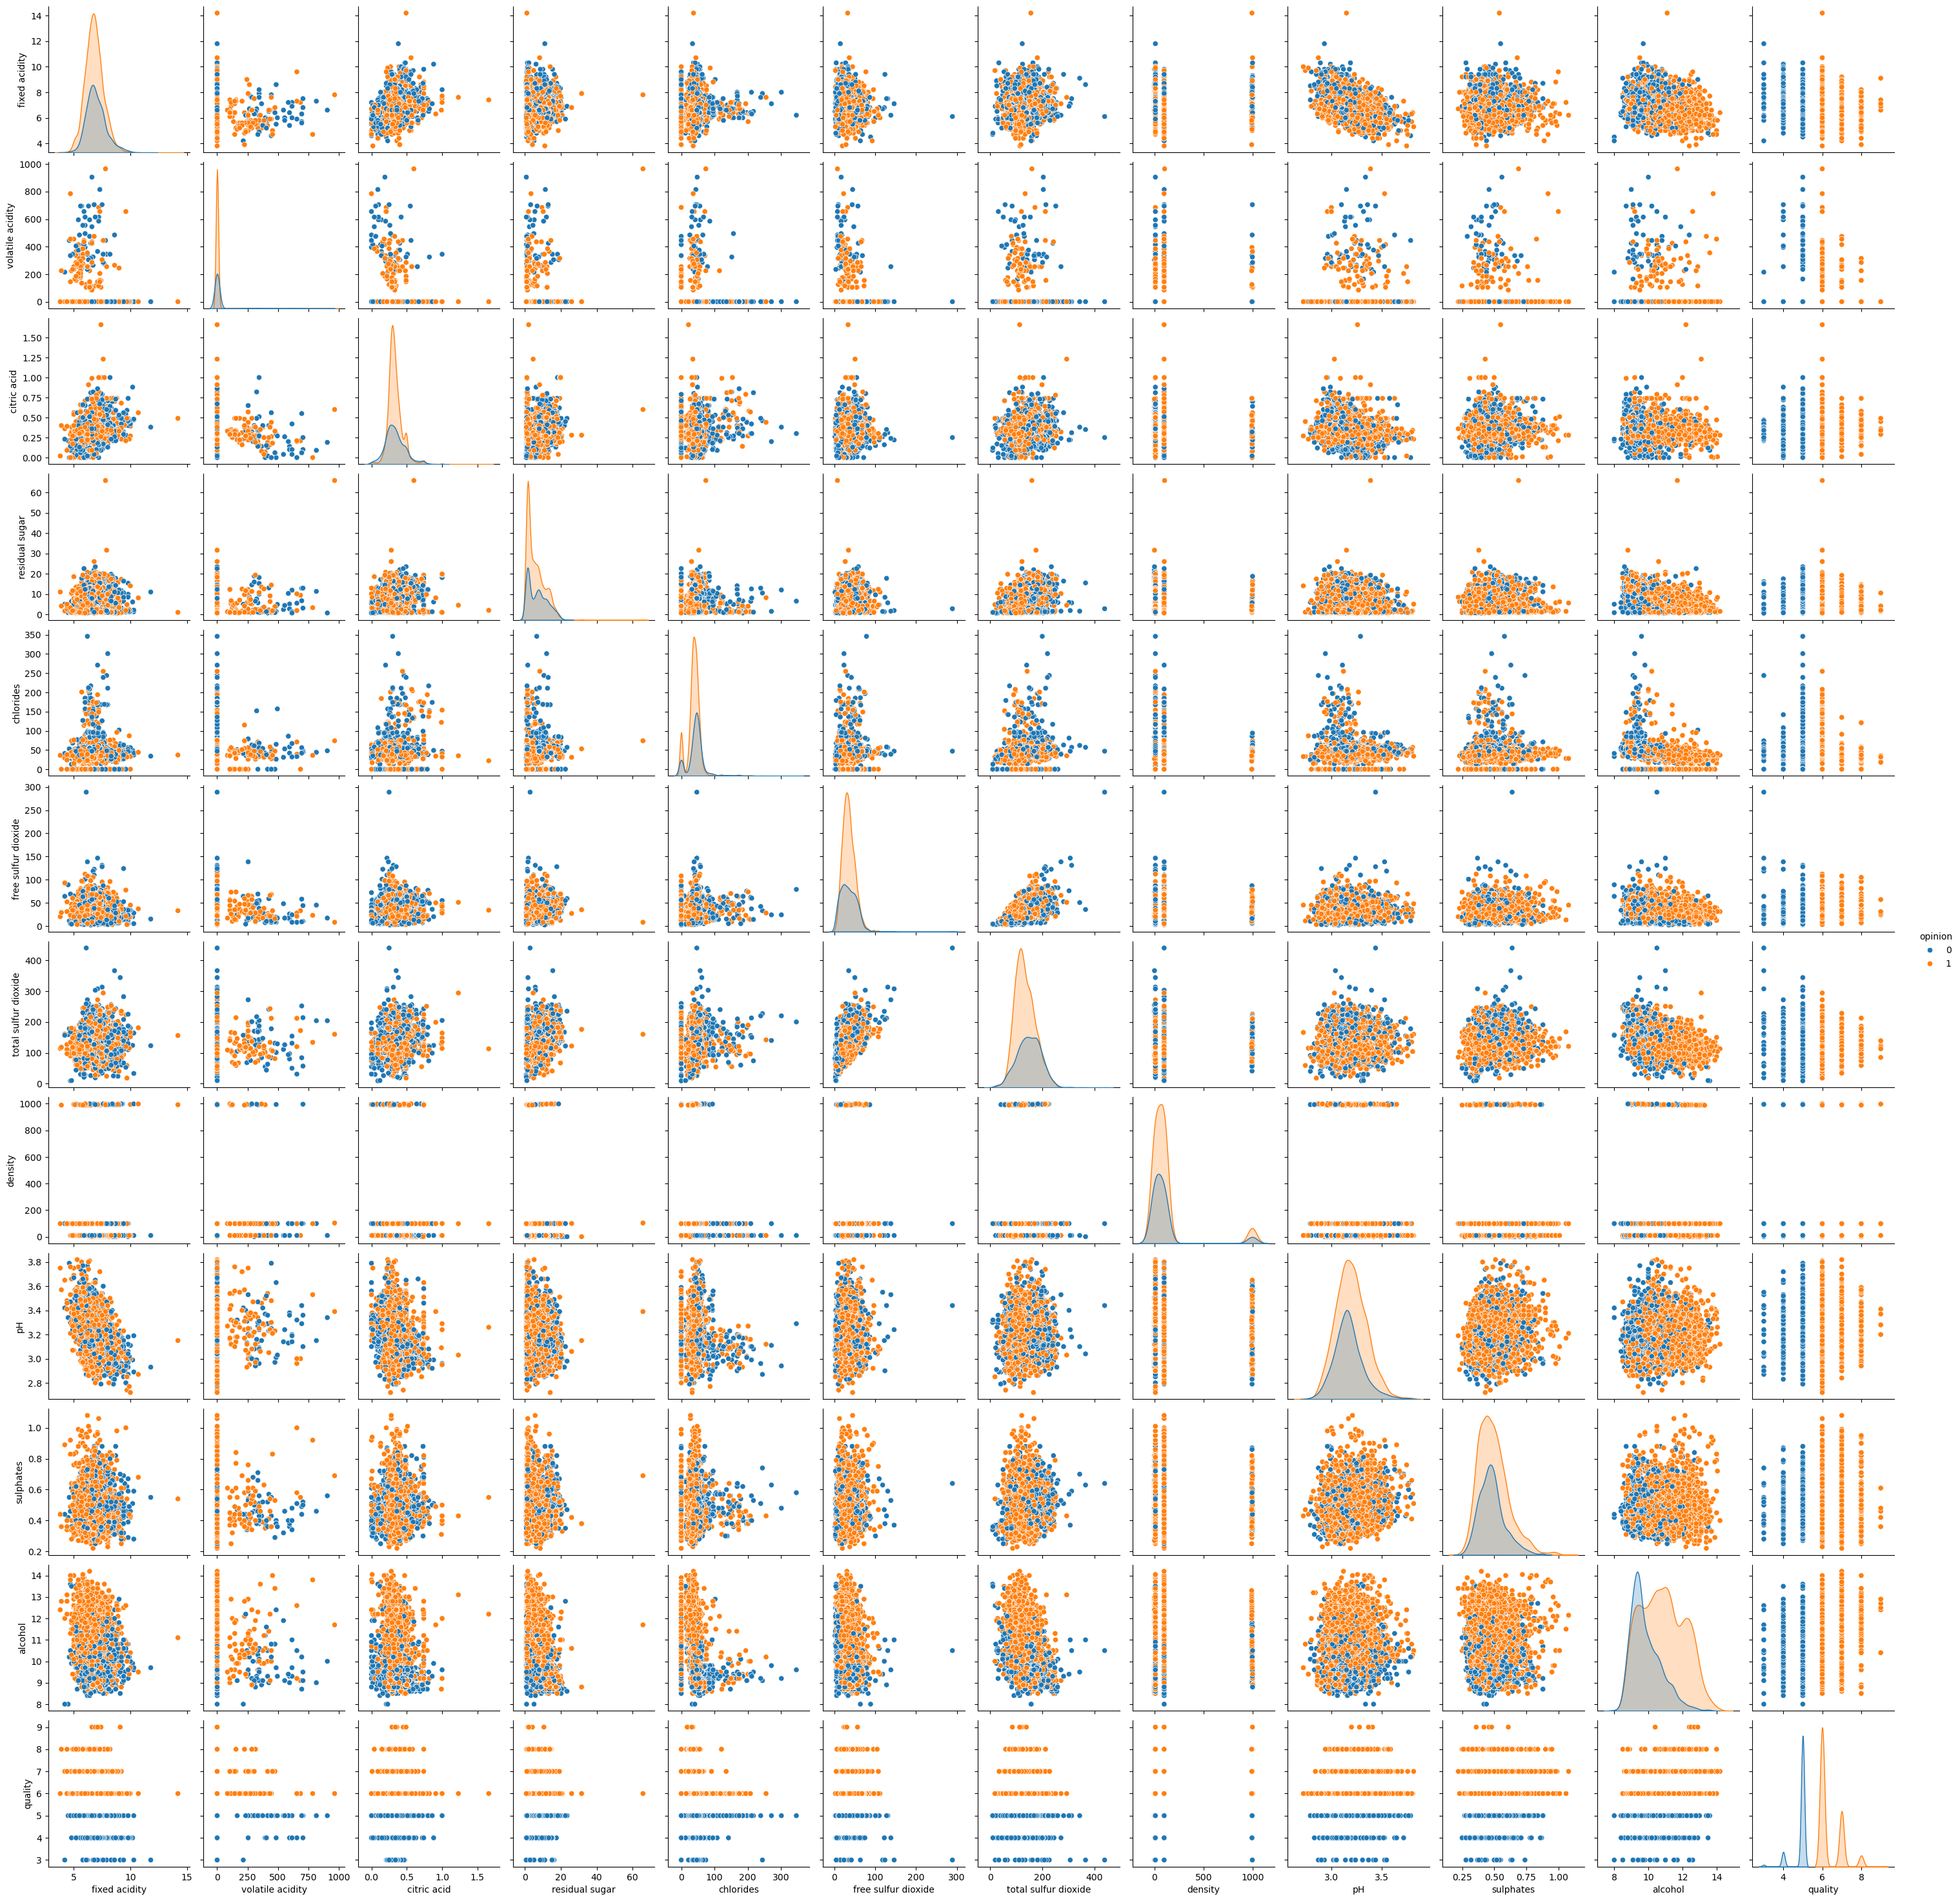

In [170]:
sb.pairplot(df_white, hue='opinion')

### Range de valores

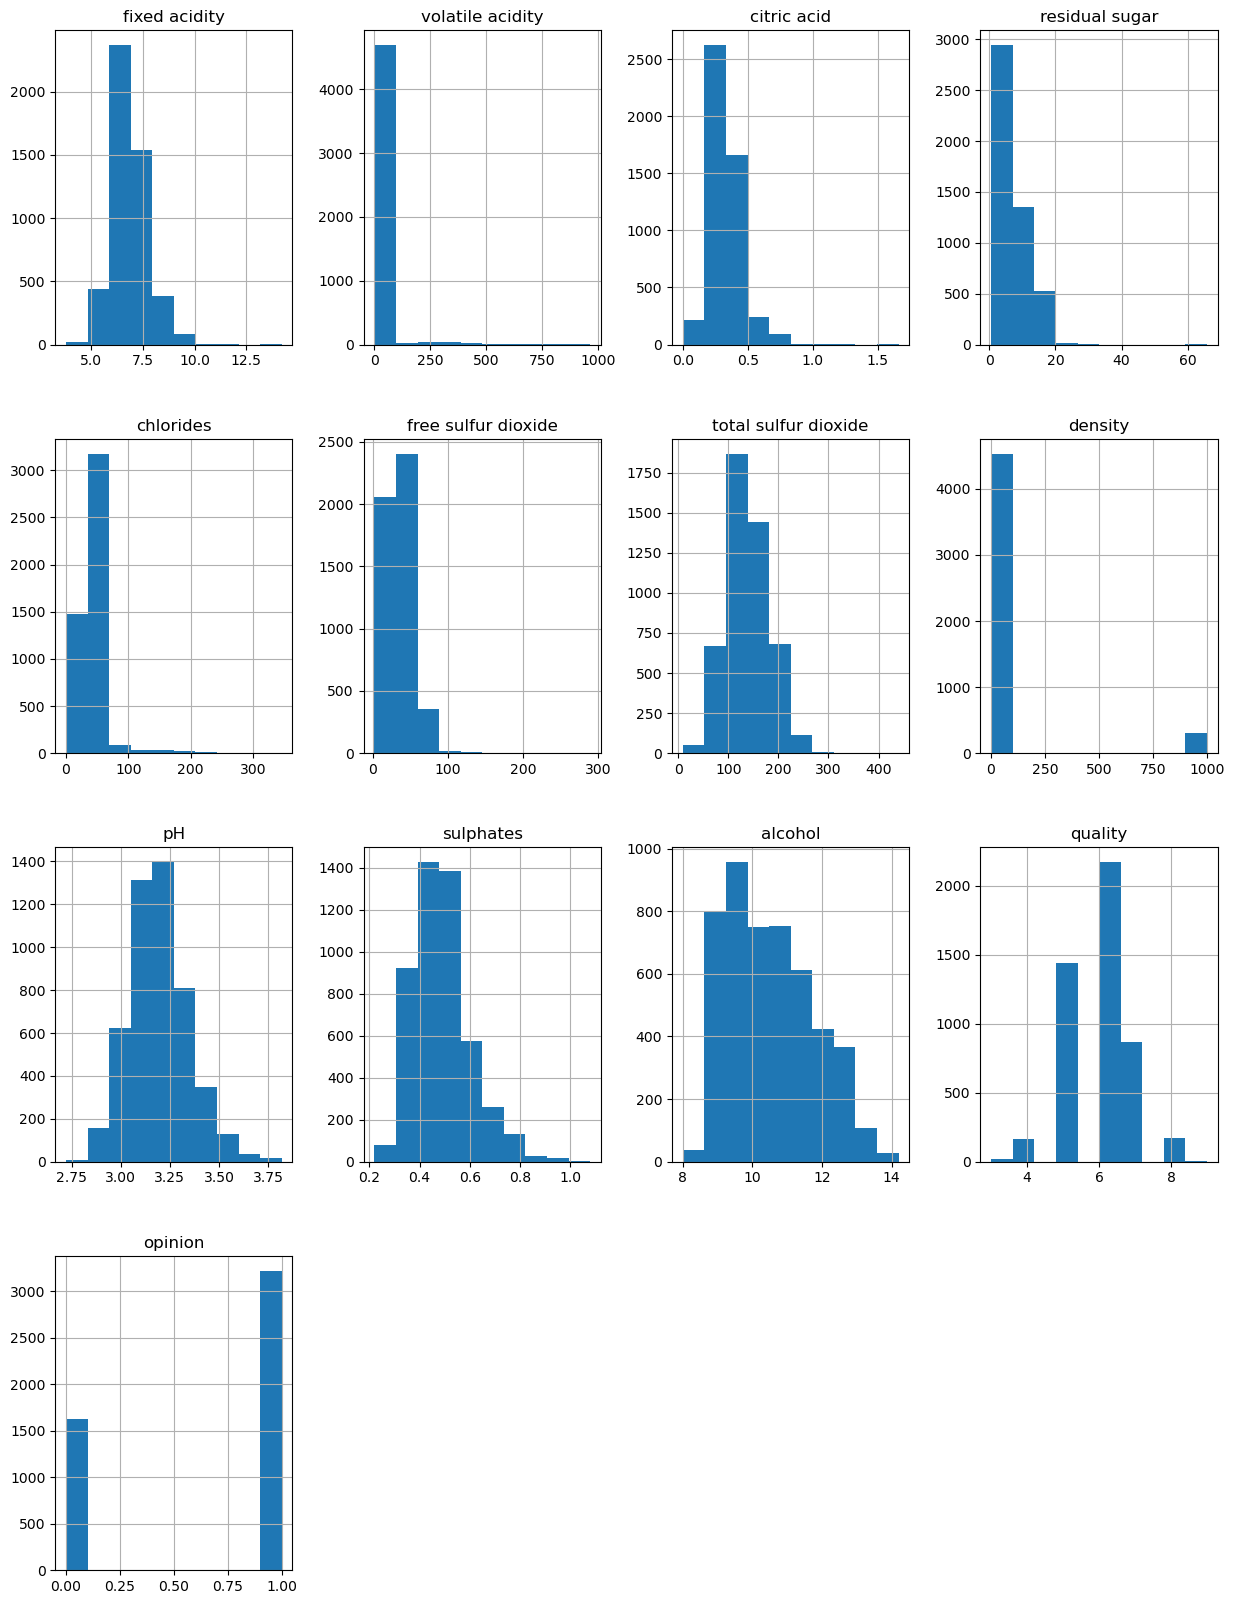

In [171]:
df_white.hist(figsize=(15,20))
plt.show()

### Correlação das features

In [172]:
df_numeric = pd.get_dummies(df, drop_first=True)  # Converte variáveis categóricas em numéricas
corr = df_numeric.corr()
corr_target = corr['opinion'].sort_values(ascending=False)
print(corr_target)

opinion                 1.000000
quality                 0.814468
alcohol                 0.395007
type_white              0.118379
citric acid             0.075392
free sulfur dioxide     0.045054
sulphates               0.034784
pH                      0.019615
density                 0.014341
residual sugar         -0.030913
total sulfur dioxide   -0.045944
fixed acidity          -0.068469
volatile acidity       -0.109649
chlorides              -0.135689
Name: opinion, dtype: float64


### Preparação dos dados
De acordo com o gráfico (opinion) acima, temos uma classe desbalanceada, onde o vinho de maior qualidade é praticamente o dobro da quantidade do vinho de menor qualidade.

Para uma classificação eficiente, devemos normalizar os dados.

In [173]:
from sklearn.model_selection import train_test_split


df_features = list(df_white.columns.values)
df_features.remove('type')
df_features.remove('quality')

target = df_features.pop(-1)
X = df_white[df_features].to_numpy()
y = df_white[target]


# separando treino e teste - com estratificação
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

props = pd.DataFrame(y.value_counts(normalize=True).values, columns=['original'])
props['train'] = y_train.value_counts(normalize=True).values
props['test'] = y_test.value_counts(normalize=True).values
props

original     train      test
0  0.664806  0.664697  0.665059
1  0.335194  0.335303  0.334941

### Modelo Baseline

In [174]:
# criar um modelo baseline
y_base = np.repeat(1, repeats=y_test.shape[0])
print(classification_report(y_test, y_base))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       486
           1       0.67      1.00      0.80       965

    accuracy                           0.67      1451
   macro avg       0.33      0.50      0.40      1451
weighted avg       0.44      0.67      0.53      1451



/opt/miniconda3/envs/infnet-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/infnet-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/infnet-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

### Split dos dados de treino e teste
Utilizando método estratificado e kfold = 10

In [175]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

### Regressão logística

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.60      0.46      0.52      1135
           1       0.76      0.85      0.80      2250

    accuracy                           0.71      3385
   macro avg       0.68      0.65      0.66      3385
weighted avg       0.70      0.71      0.70      3385

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.60      0.41      0.49       486
           1       0.74      0.86      0.80       965

    accuracy                           0.71      1451
   macro avg       0.67      0.64      0.64      1451
weighted avg       0.70      0.71      0.69      1451



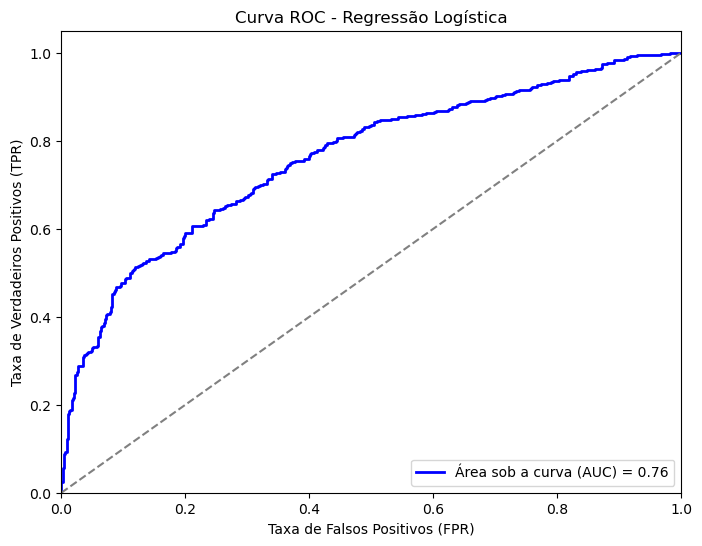

In [176]:
lreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=500, random_state=random_seed))
])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Regularização
    'model__penalty': ['l1', 'l2'],  # Penalização L1 (Lasso) ou L2 (Ridge)
    'model__solver': ['liblinear', 'saga']  # Solvers compatíveis com L1 e L2
}

lreg_search = GridSearchCV(
    estimator=lreg_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    refit=True,
    error_score=0,
    verbose=0
)

lreg_search.fit(x_train, y_train)

lreg_train = lreg_search.best_estimator_.predict(x_train)
lreg_test = lreg_search.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino')
print(classification_report(y_train, lreg_train))

print('Desempenho - Base de Teste')
print(classification_report(y_test, lreg_test))

# Obtendo as probabilidades preditas para a classe positiva (label 1)
lreg_test_proba = lreg_search.best_estimator_.predict_proba(x_test)[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, lreg_test_proba)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área sob a curva (AUC) = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha diagonal (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc='lower right')
plt.show()


<h3>Árvore de decisão</h3>

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1135
           1       0.88      0.88      0.88      2250

    accuracy                           0.84      3385
   macro avg       0.82      0.82      0.82      3385
weighted avg       0.84      0.84      0.84      3385

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.67      0.62      0.64       486
           1       0.82      0.84      0.83       965

    accuracy                           0.77      1451
   macro avg       0.74      0.73      0.74      1451
weighted avg       0.77      0.77      0.77      1451



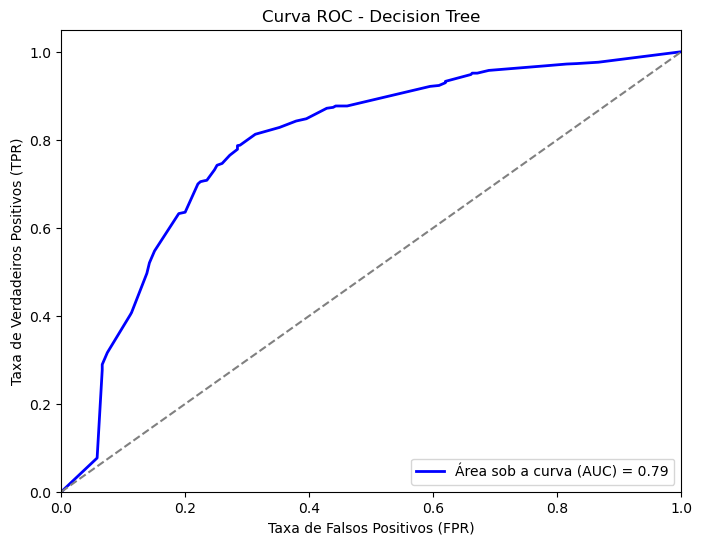

In [177]:
dtree_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=random_seed))
])

params_grid = {
    'model__max_depth': range(2, 10),
    'model__criterion': ['gini', 'entropy']
}

dtree_search = GridSearchCV(
    estimator=dtree_pipeline,
    param_grid=params_grid,
    scoring='accuracy',
    cv=kfold,
    refit=True,
    error_score=0,
    verbose=0
)
dtree_search.fit(x_train, y_train)

dtree_train = dtree_search.best_estimator_.predict(x_train)
dtree_test = dtree_search.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino')
print(classification_report(y_train, dtree_train))

print('Desempenho - Base de Teste')
print(classification_report(y_test, dtree_test))


# Plotando a curva ROC
# Obtendo as probabilidades preditas para a classe positiva (label 1)
dtree_test_proba = dtree_search.best_estimator_.predict_proba(x_test)[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, dtree_test_proba)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área sob a curva (AUC) = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha diagonal (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.show()


### SVM

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      1135
           1       0.82      0.90      0.86      2250

    accuracy                           0.80      3385
   macro avg       0.79      0.75      0.76      3385
weighted avg       0.80      0.80      0.80      3385

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.69      0.53      0.60       486
           1       0.79      0.88      0.83       965

    accuracy                           0.76      1451
   macro avg       0.74      0.71      0.72      1451
weighted avg       0.76      0.76      0.76      1451



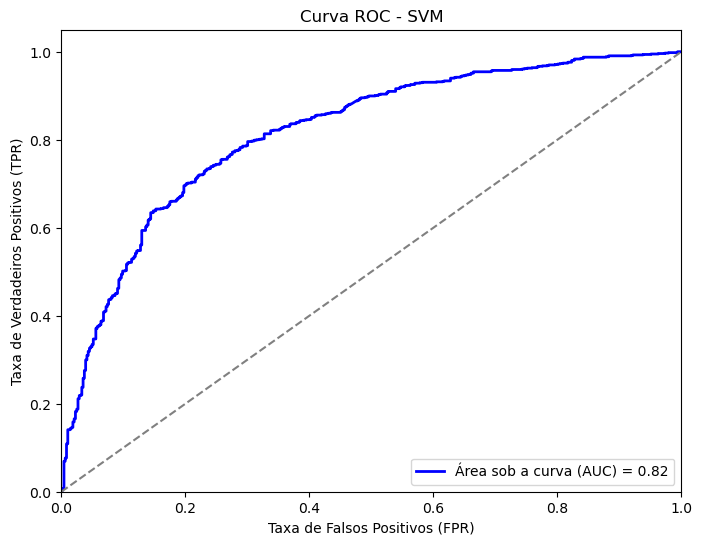

In [184]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(probability=True, random_state=random_seed))
])

params_grid = {
    'model__kernel': ['rbf', 'sigmoid', 'linear'],
    # 'model__C': np.random.uniform(0.01, 10, 100),
    # 'model__gamma': np.random.uniform(0.01, 10, 100),
}

svm_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=params_grid,
    scoring='accuracy',
    cv=kfold,
    refit=True,
    error_score=0,
    verbose=0
)

svm_search.fit(x_train, y_train)

svm_train = svm_search.best_estimator_.predict(x_train)
svm_test = svm_search.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino')
print(classification_report(y_train, svm_train))

print('Desempenho - Base de Teste')
print(classification_report(y_test, svm_test))

# Plotando a curva ROC
# Obtendo as probabilidades preditas para a classe positiva (label 1)
svm_test_proba = svm_search.best_estimator_.predict_proba(x_test)[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, svm_test_proba)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área sob a curva (AUC) = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha diagonal (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - SVM')
plt.legend(loc='lower right')
plt.show()


# Melhor modelo
De acordo com a curva Roc o melhor modelo foi o SVM com 81% de acurácia.

Ao rodar o melhor modelo com a base de dados de vinhos tinto, não foi possível obter o mesmo resultado.

Provavelmente os dados de qualidade diferem entre as classes "branco" e "tinto", sendo necessário um novo treinamento utilizando ambas as bases ou um treinamento específico para vinhos tintos.

In [179]:
df_red = df[df['type'] == 'red']
df_red.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
4898  red            7.4              0.70         0.00             1.9   
4899  red            7.8              0.88         0.00             2.6   
4900  red            7.8              0.76         0.04             2.3   
4901  red           11.2              0.28         0.56             1.9   
4902  red            7.4              0.70         0.00             1.9   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
4898       76.0                 11.0                  34.0    9.978  3.51   
4899       98.0                 25.0                  67.0    9.968  3.20   
4900       92.0                 15.0                  54.0  997.000  3.26   
4901       75.0                 17.0                  60.0  998.000  3.16   
4902       76.0                 11.0                  34.0    9.978  3.51   

      sulphates  alcohol  quality  opinion  
4898       0.56      9.4        5        0  
4899       0.68      9.8        5        0  
4900       0.65      9.8        5        0  
4901       0.58      9.8        6        1  
4902       0.56      9.4        5        0

In [180]:
df_red_features = list(df_red.columns.values)
df_red_features.remove('type')
df_red_features.remove('quality')

red_target = df_red_features.pop(-1)
X_red = df_red[df_red_features].to_numpy()
y_red = df_red[target]

y_red

4898    0
4899    0
4900    0
4901    1
4902    0
       ..
6491    1
6492    0
6494    1
6495    0
6496    1
Name: opinion, Length: 1587, dtype: int64

In [181]:
# Normalizando as features do wine red
scaler = StandardScaler()
X_scaled_red = scaler.fit_transform(X_red)
X_scaled_red

array([[-0.53321032, -0.35199476, -1.39399464, ...,  1.29366069,
        -0.57562876, -0.95850735],
       [-0.30295052, -0.35120133, -1.39399464, ..., -0.71855041,
         0.13088543, -0.58225254],
       [-0.30295052, -0.35173029, -1.18879863, ..., -0.3290902 ,
        -0.04574312, -0.58225254],
       ...,
       [-1.16642479, -0.35283228, -0.7271076 , ...,  0.70947037,
         0.5430187 ,  0.54651189],
       [-1.3966846 ,  2.48805459, -0.77840661, ...,  1.6831209 ,
         0.30751397, -0.20599773],
       [-1.33911964, -0.35371387,  1.01705849, ...,  0.51474026,
         0.01313306,  0.54651189]])

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       742
           1       0.00      0.00      0.00       845

    accuracy                           0.47      1587
   macro avg       0.23      0.50      0.32      1587
weighted avg       0.22      0.47      0.30      1587



/opt/miniconda3/envs/infnet-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/infnet-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/infnet-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

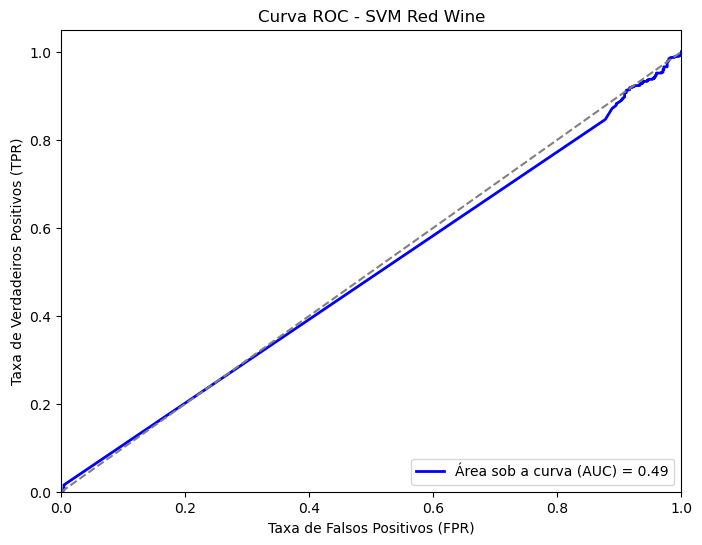

In [182]:
svm_red_test = svm_search.best_estimator_.predict(X_scaled_red)

print('Desempenho - Base de Teste')
print(classification_report(y_red, svm_red_test))

# Plotando a curva ROC
# Obtendo as probabilidades preditas para a classe positiva (label 1)
svm_red_test_proba = svm_search.best_estimator_.predict_proba(X_scaled_red)[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_red, svm_red_test_proba)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Área sob a curva (AUC) = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha diagonal (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - SVM Red Wine')
plt.legend(loc='lower right')
plt.show()